### Python Package Dependency Installation

In [0]:
!pip install fasttext
!pip install gensim
!pip install numpy
!pip install nltk
!pip install pandas
!pip install sklearn
!pip install pickle
!pip install vaderSentiment
!pip install wordcloud

!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin

import nltk
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2381465 sha256=248fce2e566739b9afe30e0c3b2db9083f559b9d9f98f222b167cd2ff3ffd9a2
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext
  ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
     |████████████████████████████████| 133kB 4.6MB/s 
--2019-08-23 10:31:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.107.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.107.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]  

True

### Sentiment Analysis Utility


In [0]:
from sklearn.utils import resample
import numpy as np
import pickle
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string
import os
import re

class SentimentUtils():

  def __init__(self):
    SentimentUtils.pretrained_w2v_model = None

  def balance_df(self, df, target_column="score"):

    # Find all labels:
    label_list = np.unique(df[target_column])

    # Find most frequent label:
    most_freq_label = np.max(df[target_column])

    # Find count of most frequent label
    most_freq_label_count = len(df[df[target_column]==most_freq_label])
    
    # Resample each label
    df_upsampled = None
    for l in label_list:
      if (l==most_freq_label):
        df_minority_upsampled = df[df[target_column]==l]
      else:
        df_minority = df[df[target_column]==l]
        df_minority_upsampled = resample(df_minority, 
                                    replace=True,     
                                    n_samples=most_freq_label_count,   
                                    random_state=10) 
      if (df_upsampled is None):
        df_upsampled = df_minority_upsampled
      else:
        df_upsampled = pd.concat([df_upsampled, df_minority_upsampled])

    df_upsampled.reset_index(inplace=True)
    df_upsampled.drop(["index"], axis=1,inplace=True)
    return df_upsampled

  def replace_emoticon(self, word):
    check_pos = re.findall(r'(?::\)|:-\)|=\)|:D|:d|<3|\(:|:\'\)|\^\^|;\)|\(-:)', word)
    check_neg = re.findall(r'(:-\(|:\(|;\(|;-\(|=\(|:/|:\\|-_-|\):|\)-:)', word)
    if check_pos:      
      word = "good"
    elif check_neg:      
      word = "bad"
    return word

  def preprocess(self, dt):
    # replace emoticons
    dt = ' '.join([self.replace_emoticon(w) for w in dt.split(' ')])		

    # tokenize all sentences
    words = word_tokenize(dt.lower())   		

    # clear punctuations
    exclude = set(string.punctuation)
    dt = ''.join(ch for ch in words if ch not in exclude)     

    # remove stopwords
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words and len(word)>1]   

    # remove all tokens that are not alphabetic
    words = [word for word in words if word.isalpha()] 

    # stemming
    #stemmer = SnowballStemmer("english")
    #words = [stemmer.stem(word) for word in words]    

    return words 


  def load_dataset(self, filename):
    with open(filename, "rb") as input_file:
      data = pickle.load(input_file)

    # Preprocess
    for i in range(0,len(data)):
      data[i][0] = " ".join(self.preprocess(data[i][0]))
      data[i][1] = " ".join(self.preprocess(data[i][1]))

    return data

  def calculate_sentence_signature(self, sentence, embedding_model, do_preprocess = False):    
    sentenceWords = word_tokenize(sentence) if (do_preprocess==False) else self.preprocess(sentence)      
    sentence_vectors = []

    for w in sentenceWords:
      try:
        sentence_vectors.append(embedding_model[w])
      except:         
        pass

    if (len(sentence_vectors)==0):
        return []

    sentence_vectors = np.array(sentence_vectors)
    signature = np.mean(sentence_vectors, axis=0)
    return signature

  def create_fasttext_training_file(self, df, fname="processed_dataset.txt"):
    # Prepare training file for fasttext
    if os.path.exists(fname):
      os.remove(fname)

    file_handle = open(fname,"a")

    for index, row in df.iterrows():
      #file_handle.write("__label__{} {}\n".format(row["score"], row["comment"])) 
      file_handle.write("{}\n".format(row["comment"])) 

    file_handle.close() 

  def create_sentence_signatures(self, upsampled_df_train, upsampled_df_test, model):
    # Calculate training sentence signatures
    train_sentence_signatures = []
    train_sentence_score = []
    for i, row in upsampled_df_train.iterrows():
        current_signature = self.calculate_sentence_signature(row["comment"], model)
        if (len(current_signature) > 0):        
          train_sentence_signatures.append(current_signature)    
          train_sentence_score.append(int(row["score"]))     

    # Calculate test sentence signatures
    test_sentence_signatures = []
    test_sentence_score = []
    for i, row in upsampled_df_test.iterrows():
        current_signature = self.calculate_sentence_signature(row["comment"], model)
        if (len(current_signature) > 0):
          test_sentence_signatures.append(current_signature)    
          test_sentence_score.append(int(row["score"]))    

    return train_sentence_signatures, train_sentence_score, test_sentence_signatures, test_sentence_score

  def create_w2v_embedding(self, X_train, fold_id, use_pretrained_model = True):  
    from gensim import models

    if (use_pretrained_model==True): 
      if (SentimentUtils.pretrained_w2v_model==None):
        SentimentUtils.pretrained_w2v_model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
      return SentimentUtils.pretrained_w2v_model  

    else:      
      if (SentimentUtils.pretrained_w2v_model==None):
        from gensim.models import KeyedVectors
        from gensim.models import Word2Vec

        context = []
        for r in  X_train:
          context.append(self.preprocess(r))

        model_2 = Word2Vec(size=300, min_count=3)
        model_2.build_vocab(context)
        total_examples = model_2.corpus_count

        model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        model_2.build_vocab([list(model.vocab.keys())], update=True)
        model_2.intersect_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
        model_2.train(context, total_examples=total_examples, epochs=model_2.iter)
        SentimentUtils.pretrained_w2v_model = model_2
      return SentimentUtils.pretrained_w2v_model  



      #import gensim
      #from gensim.models import Word2Vec
      #model = Word2Vec(context, min_count=3, size=100, window=3)  
      return model_2

  def create_fasttext_embedding(self, fold_id, df_train):
    fasttext_tr_filename = "processed_dataset_for_fold_{}.txt".format(fold_id)
    self.create_fasttext_training_file(df_train, fname=fasttext_tr_filename)
    # Train & save fasttext word embedding model
    model = fasttext.train_unsupervised(fasttext_tr_filename, model='cbow')
    model.save_model("fasttext_processed_model_for_fold_{}.bin".format(fold_id))

    return model

  def train_and_test_RF_classification_model(self, x_train, y_train, x_test, y_test, max_depth = 100):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=max_depth, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                oob_score=False, random_state=0, verbose=0, warm_start=False)

    clf.fit(x_train, y_train) 
    predictions = clf.predict(x_test)

    from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
    print(classification_report(y_test, predictions, target_names=["1","2","3","4","5"]))
    print(accuracy_score(y_test, predictions))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, predictions,labels=[1,2,3,4,5]))

    from sklearn.metrics import f1_score
    return f1_score(y_test, predictions, average='micro'), accuracy_score(y_test, predictions), clf


  def train_and_test_RF_regression_model(self, x_train, y_train, x_test, y_test, max_depth = 30):
    
    from sklearn.ensemble import RandomForestRegressor
    clf = RandomForestRegressor(bootstrap=True,
                max_depth=max_depth, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                oob_score=False, random_state=0, verbose=0, warm_start=False)

    clf.fit(x_train, y_train) 
    predictions = clf.predict(x_test)

    from sklearn.metrics import mean_squared_error
    from math import sqrt
    def mean_absolute_percentage_error(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    rmse = sqrt(mean_squared_error(y_test, predictions))
    print('Test RMSE: %.3f' % rmse)

    mape = mean_absolute_percentage_error(y_test, predictions)
    print('Test MAPE: %.3f' % mape)

    return rmse, mape, clf

  def test_with_vader_method(self, context_test, test_sentence_score):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyser = SentimentIntensityAnalyzer()

    predictions = []
    for t in context_test:
      r = analyser.polarity_scores(t)
      vader_score = (r["compound"]+1)*2.5
      predictions.append(vader_score)
    
    predictions = np.array(predictions)
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    def mean_absolute_percentage_error(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    rmse = sqrt(mean_squared_error(test_sentence_score, predictions))
    print('Vader Test RMSE: %.3f' % rmse)
    mape = mean_absolute_percentage_error(test_sentence_score, predictions)
    print('Vader Test MAPE: %.3f' % mape)

    return rmse, mape
  

### Visualization

1 scored comment count: 626
2 scored comment count: 188
3 scored comment count: 307
4 scored comment count: 761
5 scored comment count: 2229


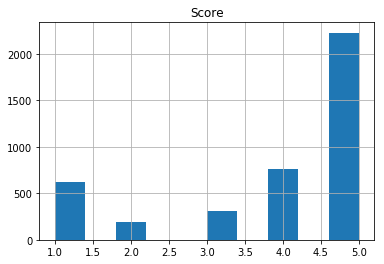

In [0]:
import pandas as pd
utils = SentimentUtils()
data = utils.load_dataset("rebtel_comments.pickle")
data = pd.DataFrame(data, columns=["Title","Comment","Score"]) 
data.hist()

for t in range(1,6):
  print("{} scored comment count: {}".format(t, len(data.loc[data["Score"]==t])))

### Word Embedding Based RF Classification & Regression Results

In [0]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import fasttext
import pickle
import warnings
warnings.filterwarnings("ignore")

utils = SentimentUtils()
# Load dataset
data = utils.load_dataset("rebtel_comments.pickle")
data = np.array(data)

X = data[:,1]
y = data[:,2]
skf = StratifiedKFold(n_splits=5, random_state=10)

param_results = pd.DataFrame()

max_depths = [5, 10, 15, 20, 25, 30]
for max_depth in max_depths:
  fold_id = 1
  mean_fscore = 0
  mean_rmse = 0
  mean_mape = 0
  mean_acc = 0

  for train_index, test_index in skf.split(X, y):
    print("==================== (W2V Based) Fold - {} Report Start  ====================".format(fold_id))
    print("Fold-id: {}, training item count: {}, test item count: {}".format(fold_id, len(train_index), len(test_index)))  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Convert to dataframe
    df_train = pd.DataFrame(zip(X_train,y_train), columns=["comment","score"]) 
    df_test = pd.DataFrame(zip(X_test,y_test), columns=["comment","score"]) 

    # Balance train set
    upsampled_df_train = utils.balance_df(df_train)
    upsampled_df_test  = df_test

    # Create word embeddings
    #model = utils.create_fasttext_embedding(fold_id, df_train)
    model = utils.create_w2v_embedding(X_train, fold_id, use_pretrained_model=False)
    
    # Calculate train/test sentence signatures
    train_sentence_signatures, train_sentence_score, test_sentence_signatures, test_sentence_score = utils.create_sentence_signatures(upsampled_df_train, upsampled_df_test, model)
    
    # Save training signatures
    with open('train_sentence_signatures_for_fold_{}.npy'.format(fold_id), 'wb') as handle:
        pickle.dump(train_sentence_signatures, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Save test signatures 
    with open('test_sentence_signatures_for_fold_{}.npy'.format(fold_id), 'wb') as handle:
        pickle.dump(test_sentence_signatures, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Save classification model
    print("=>(W2V Based) Classification Model Results for Fold - {}: ".format(fold_id))
    f1_score, accuracy, classification_model = utils.train_and_test_RF_classification_model(train_sentence_signatures, train_sentence_score, test_sentence_signatures, test_sentence_score, max_depth=max_depth)  
    with open('RF_classification_model_for_fold_{}.npy'.format(fold_id), 'wb') as handle:
        pickle.dump(classification_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save regression model
    print("=>(W2V Based) Regression Model Results for Fold - {}: ".format(fold_id))
    rmse, mape, regression_model = utils.train_and_test_RF_regression_model(train_sentence_signatures, train_sentence_score, test_sentence_signatures, test_sentence_score, max_depth=max_depth)  
    with open('RF_regression_model_for_fold_{}.npy'.format(fold_id), 'wb') as handle:
        pickle.dump(regression_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    mean_fscore = mean_fscore + f1_score
    mean_rmse = mean_rmse + rmse
    mean_mape = mean_mape + mape
    mean_acc = mean_acc + accuracy
    
    print("==================== (W2V Based) Fold - {} Report End  ====================".format(fold_id))
    fold_id = fold_id + 1

  param_results = param_results.append([[max_depth, mean_acc/5, mean_fscore/5, mean_rmse/5, mean_mape/5, mean_mape/500]])  

param_results = param_results.reset_index()
param_results = param_results.drop(["index"], axis=1)
param_results.rename(columns={
                          0:'MAX_DEPTH',
                          1:'Accuracy',
                          2:'FScore',
                          3:'RMSE',
                          4:'MAPE',
                          5:'MAE'
                          }, 
                      inplace=True)

param_results = param_results.set_index('MAX_DEPTH')
param_results

==================== (W2V Based) Fold - 1 Report Start  ====================
Fold-id: 1, training item count: 3286, test item count: 825
=>(W2V Based) Classification Model Results for Fold - 1: 
              precision    recall  f1-score   support

           1       0.63      0.56      0.60       124
           2       0.11      0.16      0.13        37
           3       0.18      0.31      0.22        61
           4       0.29      0.25      0.27       153
           5       0.79      0.73      0.76       443

    accuracy                           0.56       818
   macro avg       0.40      0.41      0.40       818
weighted avg       0.60      0.56      0.58       818

0.5611246943765281
Confusion matrix:
[[ 70  20  21   6   7]
 [ 12   6  10   7   2]
 [ 10  12  19  10  10]
 [  6   6  34  39  68]
 [ 13   9  24  72 325]]
=>(W2V Based) Regression Model Results for Fold - 1: 
Test RMSE: 1.088
Test MAPE: 36.596
==================== (W2V Based) Fold - 1 Report End  ====================

,Accuracy,FScore,RMSE,MAPE,MAE
MAX_DEPTH,,,,,
5,0.506435,0.506435,1.173545,37.863878,0.378639
10,0.553476,0.553476,1.099260,35.902837,0.359028
15,0.564988,0.564988,1.091563,35.758104,0.357581
20,0.563276,0.563276,1.093273,35.641996,0.356420
25,0.566451,0.566451,1.097163,35.792574,0.357926
30,0.566945,0.566945,1.098248,35.859741,0.358597


### TF.IDF Based RF Classification & Regression Results

In [0]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import fasttext
import pickle
import warnings
warnings.filterwarnings("ignore")

utils = SentimentUtils()
# Load dataset
data = utils.load_dataset("rebtel_comments.pickle")
data = np.array(data)

X = data[:,1]
y = data[:,2]
skf = StratifiedKFold(n_splits=5, random_state=10)

param_results = pd.DataFrame()

max_depths = [10, 30, 60, 100, 150, 200, 300, 400]
for max_depth in max_depths:
  fold_id = 1
  mean_fscore = 0
  mean_rmse = 0
  mean_mape = 0
  mean_rmse_vader = 0
  mean_mape_vader = 0
  mean_acc = 0

  for train_index, test_index in skf.split(X, y):
    print("==================== (TF.IDF Based) Fold - {} Report Start   ====================".format(fold_id))
    print("Fold-id: {}, training item count: {}, test item count: {}".format(fold_id, len(train_index), len(test_index)))  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Convert to dataframe
    df_train = pd.DataFrame(zip(X_train,y_train), columns=["comment","score"]) 
    df_test = pd.DataFrame(zip(X_test,y_test), columns=["comment","score"]) 

    # Balance train set
    upsampled_df_train = utils.balance_df(df_train)

    upsampled_df_train = np.array(upsampled_df_train.to_numpy())
    X_train = upsampled_df_train[:,0]
    y_train = upsampled_df_train[:,1]
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    context = []
    for r in  X_train:
      context.append(" ".join(utils.preprocess(r)))

    context_test = []
    for r in  X_test:
      context_test.append(" ".join(utils.preprocess(r)))

    vectorizer = TfidfVectorizer()
    train_sentence_signatures = vectorizer.fit_transform(context)
    test_sentence_signatures = vectorizer.transform(context_test)
    test_sentence_score = [int(t) for t in y_test]
    train_sentence_score = [int(t) for t in y_train]

    # Save classification model
    print("=>(TF.IDF Based) Classification Model Results for Fold - {}: ".format(fold_id))
    f1_score, accuracy, classification_model = utils.train_and_test_RF_classification_model(train_sentence_signatures, train_sentence_score, test_sentence_signatures, test_sentence_score, max_depth = max_depth)  
    with open('RF_classification_model_for_fold_{}.npy'.format(fold_id), 'wb') as handle:
        pickle.dump(classification_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save regression model
    print("=>(TF.IDF Based) Regression Model Results for Fold - {}: ".format(fold_id))
    rmse, mape, regression_model = utils.train_and_test_RF_regression_model(train_sentence_signatures, train_sentence_score, test_sentence_signatures, test_sentence_score, max_depth = max_depth)  
    with open('RF_regression_model_for_fold_{}.npy'.format(fold_id), 'wb') as handle:
        pickle.dump(regression_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

    rmse_vader, mape_vader = utils.test_with_vader_method(context_test, test_sentence_score)


    mean_fscore = mean_fscore + f1_score
    mean_rmse = mean_rmse + rmse
    mean_mape = mean_mape + mape
    mean_acc = mean_acc + accuracy
    mean_rmse_vader = mean_rmse_vader + rmse_vader
    mean_mape_vader = mean_mape_vader + mape_vader
    
    print("==================== (TF.IDF Based) Fold - {} Report End  ====================".format(fold_id))
    fold_id = fold_id + 1
    
  print("Mean 5-folds accuracy for classification model: " + str(mean_acc/5))
  print("Mean 5-folds fscore for classification model: " + str(mean_fscore/5))
  print("Mean 5-folds rmse for regression model: " + str(mean_rmse/5))
  print("Mean 5-folds mape for regression model: " + str(mean_mape/5))
  print("Mean 5-folds mae for regression model: " + str(mean_mape/500))
  print("Mean 5-folds vader rmse for regression model: " + str(mean_rmse_vader/5))
  print("Mean 5-folds vader mape for regression model: " + str(mean_mape_vader/5))
  print("Mean 5-folds vader mae for regression model: " + str(mean_mape_vader/500))
  param_results = param_results.append([[max_depth, mean_acc/5, mean_fscore/5, mean_rmse/5, mean_mape/5, mean_mape/500]])


param_results = param_results.reset_index()
param_results = param_results.drop(["index"], axis=1)
param_results.rename(columns={
                          0:'MAX_DEPTH',
                          1:'Accuracy',
                          2:'FScore',
                          3:'RMSE',
                          4:'MAPE',
                          5:'MAE'
                          }, 
                      inplace=True)

param_results = param_results.set_index('MAX_DEPTH')

param_results

==================== (TF.IDF Based) Fold - 1 Report Start   ====================
Fold-id: 1, training item count: 3286, test item count: 825
=>(TF.IDF Based) Classification Model Results for Fold - 1: 
              precision    recall  f1-score   support

           1       0.52      0.48      0.50       126
           2       0.14      0.13      0.13        38
           3       0.19      0.26      0.22        62
           4       0.28      0.31      0.30       153
           5       0.72      0.67      0.70       446

    accuracy                           0.52       825
   macro avg       0.37      0.37      0.37       825
weighted avg       0.54      0.52      0.53       825

0.52
Confusion matrix:
[[ 60  11  13  11  31]
 [ 13   5  11   3   6]
 [ 14   5  16  10  17]
 [ 10  10  22  48  63]
 [ 18   6  24  98 300]]
=>(TF.IDF Based) Regression Model Results for Fold - 1: 
Test RMSE: 1.299
Test MAPE: 43.384
Vader Test RMSE: 1.290
Vader Test MAPE: 42.503
==================== (TF.IDF Ba

,Accuracy,FScore,RMSE,MAPE,MAE
MAX_DEPTH,,,,,
10,0.452831,0.452831,1.353652,42.654050,0.426540
30,0.517581,0.517581,1.219604,37.195688,0.371957
60,0.556523,0.556523,1.177149,36.278585,0.362786
100,0.576253,0.576253,1.153552,36.130185,0.361302
150,0.585485,0.585485,1.156249,36.722123,0.367221
200,0.587178,0.587178,1.161328,36.774188,0.367742
300,0.595200,0.595200,1.154187,36.604550,0.366046
400,0.579157,0.579157,1.154187,36.604550,0.366046


### Ensemble

In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
import fasttext
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

utils = SentimentUtils()
# Load dataset
data = utils.load_dataset("rebtel_comments.pickle")
data = np.array(data)

X = data[:,1]
y = data[:,2]
skf = StratifiedKFold(n_splits=5, random_state=10)

param_results = pd.DataFrame()

max_depth = 25

# Try ensemble with the first fold
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  # Convert to dataframe
  df_train = pd.DataFrame(zip(X_train,y_train), columns=["comment","score"]) 
  df_test = pd.DataFrame(zip(X_test,y_test), columns=["comment","score"]) 

  # Balance train set
  upsampled_df_train = utils.balance_df(df_train)
  upsampled_df_test  = df_test

  # Create word embeddings
  model = utils.create_w2v_embedding(X_train, 0, use_pretrained_model=False)
  with open('w2v_model.bin', 'wb') as handle:
      pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)  

  # Calculate training sentence signatures
  train_sentence_signatures = []
  train_sentence_score = []
  context = []
  train_sentence_score2 = []
  for i, row in upsampled_df_train.iterrows():
      current_signature = utils.calculate_sentence_signature(row["comment"], model)
      if (len(current_signature) > 0):        
        train_sentence_signatures.append(current_signature)    
        train_sentence_score.append(int(row["score"]))
        train_sentence_score2.append(int(row["score"]))
        context.append(" ".join(utils.preprocess(row["comment"])))     

  # Calculate test sentence signatures
  test_sentence_signatures = []
  test_sentence_score = []
  context_test = []    
  test_sentence_score2 = []    
  for i, row in upsampled_df_test.iterrows():
      current_signature = utils.calculate_sentence_signature(row["comment"], model)
      if (len(current_signature) > 0):
        test_sentence_signatures.append(current_signature)    
        test_sentence_score.append(int(row["score"]))   
        test_sentence_score2.append(int(row["score"]))   
        context_test.append(" ".join(utils.preprocess(row["comment"])))

  # Save regression model
  print("=>(W2V Based) Regression Model Results")
  rmse, mape, regression_model = utils.train_and_test_RF_regression_model(train_sentence_signatures, 
                                                                          train_sentence_score, 
                                                                          test_sentence_signatures, 
                                                                          test_sentence_score, 
                                                                          max_depth=25)  
  with open('RF_regression_model_w2v.bin', 'wb') as handle:
      pickle.dump(regression_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

  upsampled_df_train = utils.balance_df(df_train)
  upsampled_df_train = np.array(upsampled_df_train.to_numpy())
  X_train = upsampled_df_train[:,0]
  y_train = upsampled_df_train[:,1]
  
  from sklearn.feature_extraction.text import TfidfVectorizer

  vectorizer = TfidfVectorizer()
  train_sentence_signatures2 = vectorizer.fit_transform(context)
  test_sentence_signatures2 = vectorizer.transform(context_test)
  
  print("=>(TF.IDF Based) Regression Model Results: ")
  rmse, mape, regression_model2 = utils.train_and_test_RF_regression_model(train_sentence_signatures2, train_sentence_score2, 
                                                            test_sentence_signatures2, test_sentence_score2, 
                                                            max_depth = 100)  
  with open('RF_regression_model_tfidf.bin', 'wb') as handle:
      pickle.dump(regression_model2, handle, protocol=pickle.HIGHEST_PROTOCOL)    

  with open('tf_idf_vectorizer.bin', 'wb') as handle:
      pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)          

  predictions1 = regression_model.predict(test_sentence_signatures)
  predictions2 = regression_model2.predict(test_sentence_signatures2)
  predictions = (predictions1+predictions2)/2

  rmse = sqrt(mean_squared_error(test_sentence_score, predictions))
  print('Ensemble Test RMSE: %.3f' % rmse)

  mape = mean_absolute_percentage_error(test_sentence_score, predictions)
  print('Ensemble Test MAPE: %.3f' % mape)
  break

=>(W2V Based) Regression Model Results
Test RMSE: 1.006
Test MAPE: 34.705
=>(TF.IDF Based) Regression Model Results: 
Test RMSE: 1.101
Test MAPE: 36.475
Ensemble Test RMSE: 0.985
Ensemble Test MAPE: 34.717


In [0]:
# Evaluate ensemble
data1 = "bought card relatively cheap however compared phone cards ive ever used rebtel really bad connection usually takes three times finally reach someone often stops working middle call disappointed want customers know price thing matters"
data2 = "I bought this card because it is relatively cheap, however, compared with other phone cards I've ever used, rebtel has really bad connection, it usually takes me three times to finally reach someone and it often stops working in the middle of a call. I am disappointed and I want customers to know that price is not the only thing matters"
data3 = "scam thief"
signatures1 = utils.calculate_sentence_signature(data3, model, do_preprocess=True)
signatures2 = vectorizer.transform([" ".join(utils.preprocess(data3))])

signatures1 = np.expand_dims(signatures1, axis=0)

prediction1 = regression_model.predict(signatures1)
prediction2 = regression_model2.predict(signatures2)
prediction = (prediction1+prediction2)/2

print("W2V score: " + str(prediction1))
print("TF.IDF score: " + str(prediction2))
print("Ensemble score: " + str(prediction))

W2V score: [2.]
TF.IDF score: [3.15473401]
Ensemble score: [2.57736701]


## Important Words


### Random Forest Regressor Feature Importance Based Word Importances w.r.t Scores (1/5)

Word importances for score - 1:
4811 account
4810 charged
4809 worst
4808 bad
4807 credit
4806 customer
4805 days
4804 trying
4803 money
4802 rebtel
4801 number
4800 hi
4799 even
4798 get
4797 refund
4796 website
4795 good
4794 charging
4793 cheating
4792 waste
4791 month
4790 per
4789 response
4788 scam
4787 horrible
4786 call
4785 one
4784 charge
4783 says
4782 due
4781 make
4780 bank
4779 people
4778 service
4777 company
4776 easy
4775 rates
4774 useless
4773 double
4772 plan
Word importances for score - 5:
4811 excellent
4810 account
4809 easy
4808 good
4807 best
4806 great
4805 call
4804 international
4803 clear
4802 credit
4801 love
4800 service
4799 rebtel
4798 recommend
4797 happy
4796 reliable
4795 quality
4794 times
4793 bad
4792 family
4791 number
4790 using
4789 expensive
4788 cheap
4787 sometimes
4786 app
4785 thanks
4784 one
4783 voice
4782 calls
4781 awesome
4780 get
4779 like
4778 thank
4777 helpful
4776 friends
4775 time
4774 cheaper
4773 works
4772 better


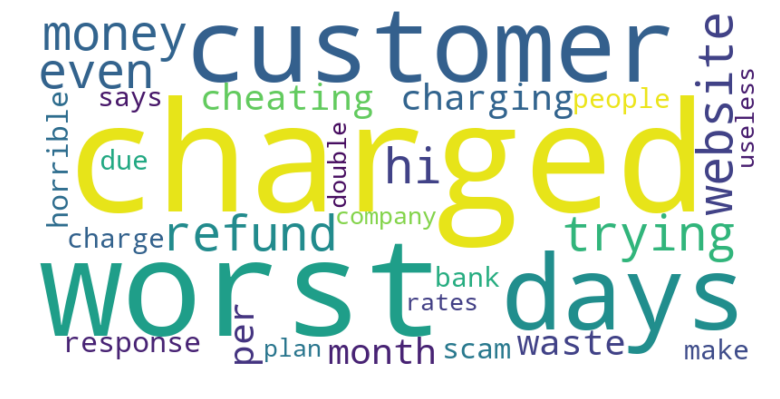

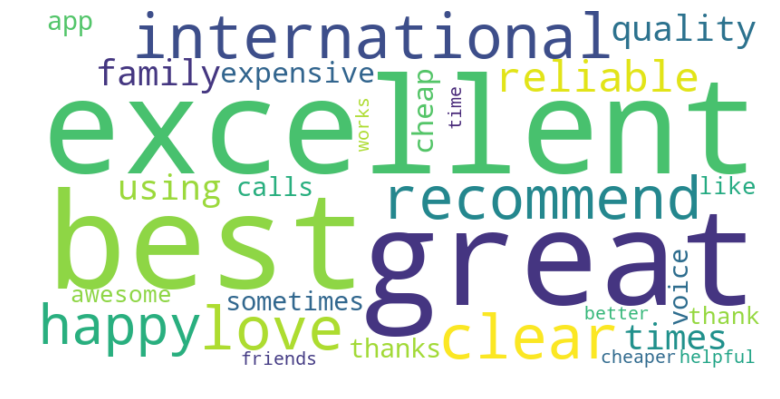

In [0]:
from matplotlib import pyplot
import numpy as np
from sklearn.model_selection import StratifiedKFold
import fasttext
import pickle
import warnings
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

utils = SentimentUtils()
data = utils.load_dataset("rebtel_comments.pickle")
data = np.array(data)

x = data[:,1]
y = data[:,2]

x_filtered = []
y_filtered = []

for t,z in zip(x,y):  
  if (int(z) > 1):
    x_filtered.append(t)
    y_filtered.append(0)    
  elif (int(z) == 1):
    x_filtered.append(t)
    y_filtered.append(1)
  
from sklearn.feature_extraction.text import TfidfVectorizer
context = []
for r in  x_filtered:
  context.append(" ".join(utils.preprocess(r)))

vectorizer = TfidfVectorizer()
x_filtered = vectorizer.fit_transform(context)
y_filtered = [int(t) for t in y_filtered]

model = RandomForestRegressor(bootstrap=True,
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

model.fit(x_filtered, y_filtered) 

print("Word importances for score - 1:")

b = np.argsort(model.feature_importances_)
word_freq_score_1 = {}
for t in reversed(range(len(b)-40,len(b))):
  w = vectorizer.get_feature_names()[b[t]]
  word_freq_score_1[w] = t
  print(str(t) + " " + w)


x_filtered = []
y_filtered = []
for t,z in zip(x,y):
  if (int(z) < 5 ):
    x_filtered.append(t)
    y_filtered.append(0)    
  elif (int(z) == 5):
    x_filtered.append(t)
    y_filtered.append(1)
  
from sklearn.feature_extraction.text import TfidfVectorizer
context = []
for r in  x_filtered:
  context.append(" ".join(utils.preprocess(r)))

vectorizer = TfidfVectorizer()
x_filtered = vectorizer.fit_transform(context)
y_filtered = [int(t) for t in y_filtered]

model2 = RandomForestRegressor(bootstrap=True,
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

model2.fit(x_filtered, y_filtered) 

print("Word importances for score - 5:")

b = np.argsort(model2.feature_importances_)
word_freq_score_2 = {}
for t in reversed(range(len(b)-40,len(b))):
  w = vectorizer.get_feature_names()[b[t]]
  word_freq_score_2[w] = t
  print(str(t) + " " + w)


word_freq_score_1_filtered = dict([(t, word_freq_score_1[t]) for t in word_freq_score_1 if t not in word_freq_score_2])
word_freq_score_2_filtered = dict([(t, word_freq_score_2[t]) for t in word_freq_score_2 if t not in word_freq_score_1])

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(word_freq_score_1_filtered)
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(stopwords=[], background_color="white", width=800, height=400).generate_from_frequencies(word_freq_score_2_filtered)
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Max TF.IDF Score Based Word Importances w.r.t Scores (1/5)



 Important words for score=1
rebtel: 0.050979190200941625
call: 0.04255448895599659
service: 0.03747297607586752
account: 0.028544408545267165
calls: 0.027737039059567013
customer: 0.026863418222784152
number: 0.025294887501440825
app: 0.02508391759676303
money: 0.02432197838744905
credit: 0.024146240691185383
make: 0.022394825262029915
get: 0.020495774279886463
time: 0.019678338338847676
phone: 0.01853867090315654
even: 0.018316660700379024
using: 0.018093815821933715
hi: 0.018048919378545
charged: 0.017414010184958376
company: 0.016566832040500717
one: 0.016239958777939534
calling: 0.015961319340634002
never: 0.015947250328776558
minutes: 0.015876253517265036
card: 0.01581319414464076
use: 0.01561359333635509
bad: 0.015354299380775888
worst: 0.015153400481972492
good: 0.014843790062153858
india: 0.014606908905038997
support: 0.013652123036835124
month: 0.013442901449925989
still: 0.013294055975389123


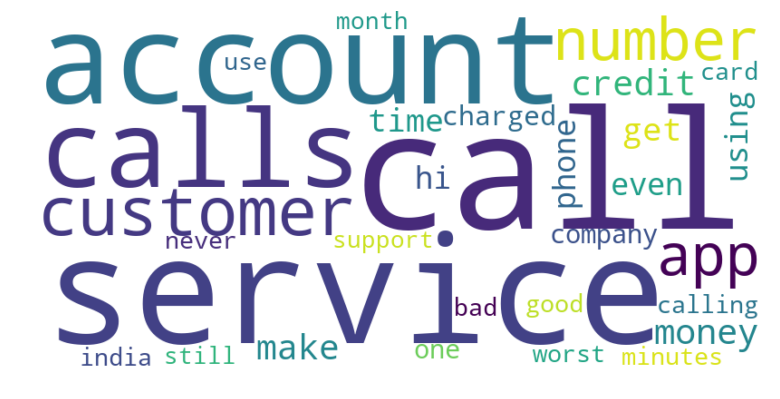


 Important words for score=5
good: 0.06773637103494394
service: 0.06520198776141907
rebtel: 0.04927591064857758
excellent: 0.046437877404239866
great: 0.038982464064206135
quality: 0.03457447782380095
call: 0.03283603012059807
easy: 0.031151750046277252
app: 0.03056723332003977
use: 0.03019303101529075
best: 0.02841667669035559
calls: 0.028280389084664025
clear: 0.02353674533160607
calling: 0.020950612139549595
cheap: 0.02000446242599502
recommend: 0.01948859264129642
love: 0.019050682787863427
international: 0.018628292473154506
using: 0.018364173774479194
really: 0.016877835038370783
like: 0.016778297613048877
happy: 0.015723242436411343
price: 0.015478369102932737
connection: 0.015370101982661397
friends: 0.01496846225484904
voice: 0.014580977664078757
phone: 0.013790171428428024
family: 0.013534591371258398
would: 0.012481529424183256
reliable: 0.012272008884894797
rates: 0.012032094490700982
customer: 0.011828352522207196


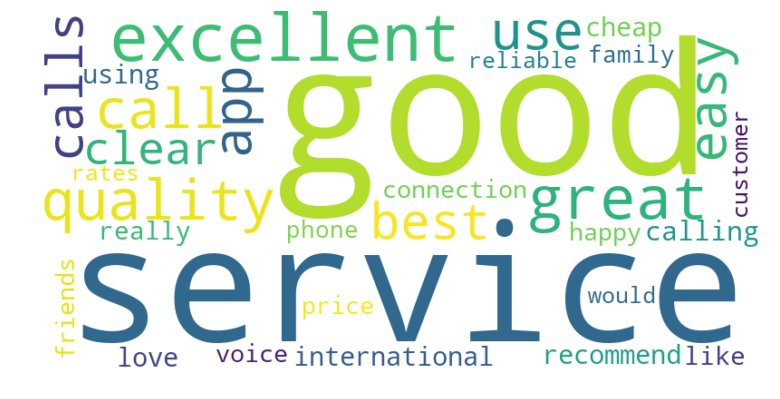

In [0]:
def print_most_important_words(data, limit = 10):
  from sklearn.feature_extraction.text import TfidfVectorizer

  corpus = []
  utils = SentimentUtils()
  for r in  data:    
    corpus.append(" ".join(utils.preprocess(r)))
  
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(corpus).todense()
  words = vectorizer.get_feature_names()
  sorted_values = np.squeeze(np.array(np.sort(np.sum(X, axis=0))))[::-1]
  sorted_weights = np.squeeze(np.array(np.argsort(np.sum(X, axis=0))))[::-1]

  t = 0
  word_freq={}
  ignore_list = ["rebtel"]
  for i,v in zip(sorted_weights, sorted_values):    
    print(words[i] + ": " +str(v/len(data)))
    if (words[i] not in ignore_list):
      word_freq[words[i]] = v
    if (t>limit):
      break          
    t = t + 1

  from wordcloud import WordCloud
  import matplotlib.pyplot as plt
  wordcloud = WordCloud(background_color="white", width=800, height=400).generate_from_frequencies(word_freq)
  from matplotlib.pyplot import figure
  figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

data = utils.load_dataset("rebtel_comments.pickle")
data = np.array(data)

# Convert to dataframe
df = pd.DataFrame(data, columns=["title", "comment","score"]) 

for s in [1,5]:
  print("\n Important words for score="+str(s))
  tmp = df[(df["score"]==str(s)) ]  
  print_most_important_words(tmp["comment"].to_numpy(), limit=30)
